# Estimating COVID-19's $R_t$ in Real-Time for EU - results

Data and estimates from April 23. See the `Realtime R0` notebook for how numbers here were derived.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland']

%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_rt(result, ax, country_name, scatter_alpha=1.0):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               alpha=scatter_alpha,
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [3]:
final_results = pd.read_csv('data/rt_mcmc.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [4]:
# TODO: fix column names in the MCMC notebook
final_results.columns = ['mean', 'ML', 'Low_90', 'High_90', 'Low_50', 'High_50']
final_results.index.names = ['country', 'date']

In [5]:
final_results

mean        ML    Low_90   High_90    Low_50  \
country        date                                                           
Austria        2020-02-16  1.575210  1.520085  1.124737  2.038819  1.323607   
               2020-02-17  1.584528  1.533016  1.143795  2.069895  1.329649   
               2020-02-18  1.594589  1.547439  1.129337  2.050175  1.321558   
               2020-02-19  1.600235  1.551479  1.120318  2.038635  1.264359   
               2020-02-20  1.608116  1.563423  1.154403  2.049411  1.342272   
...                             ...       ...       ...       ...       ...   
United_Kingdom 2020-05-01  0.987727  0.988290  0.907803  1.077153  0.959200   
               2020-05-02  0.982346  0.984062  0.895588  1.077613  0.951009   
               2020-05-03  0.977003  0.982264  0.871994  1.075110  0.942356   
               2020-05-04  0.973600  0.980810  0.864996  1.100338  0.944499   
               2020-05-05  0.973679  0.980323  0.827166  1.101000  0.946575   

                            High_50  
country        date                  
Austria        2020-02-16  1.676337  
               2020-02-17  1.681047  
               2020-02-18  1.678541  
               2020-02-19  1.620967  
               2020-02-20  1.699601  
...                             ...  
United_Kingdom 2020-05-01  1.014573  
               2020-05-02  1.012735  
               2020-05-03  1.012421  
               2020-05-04  1.021922  
               2020-05-05  1.038604  

[2560 rows x 6 columns]

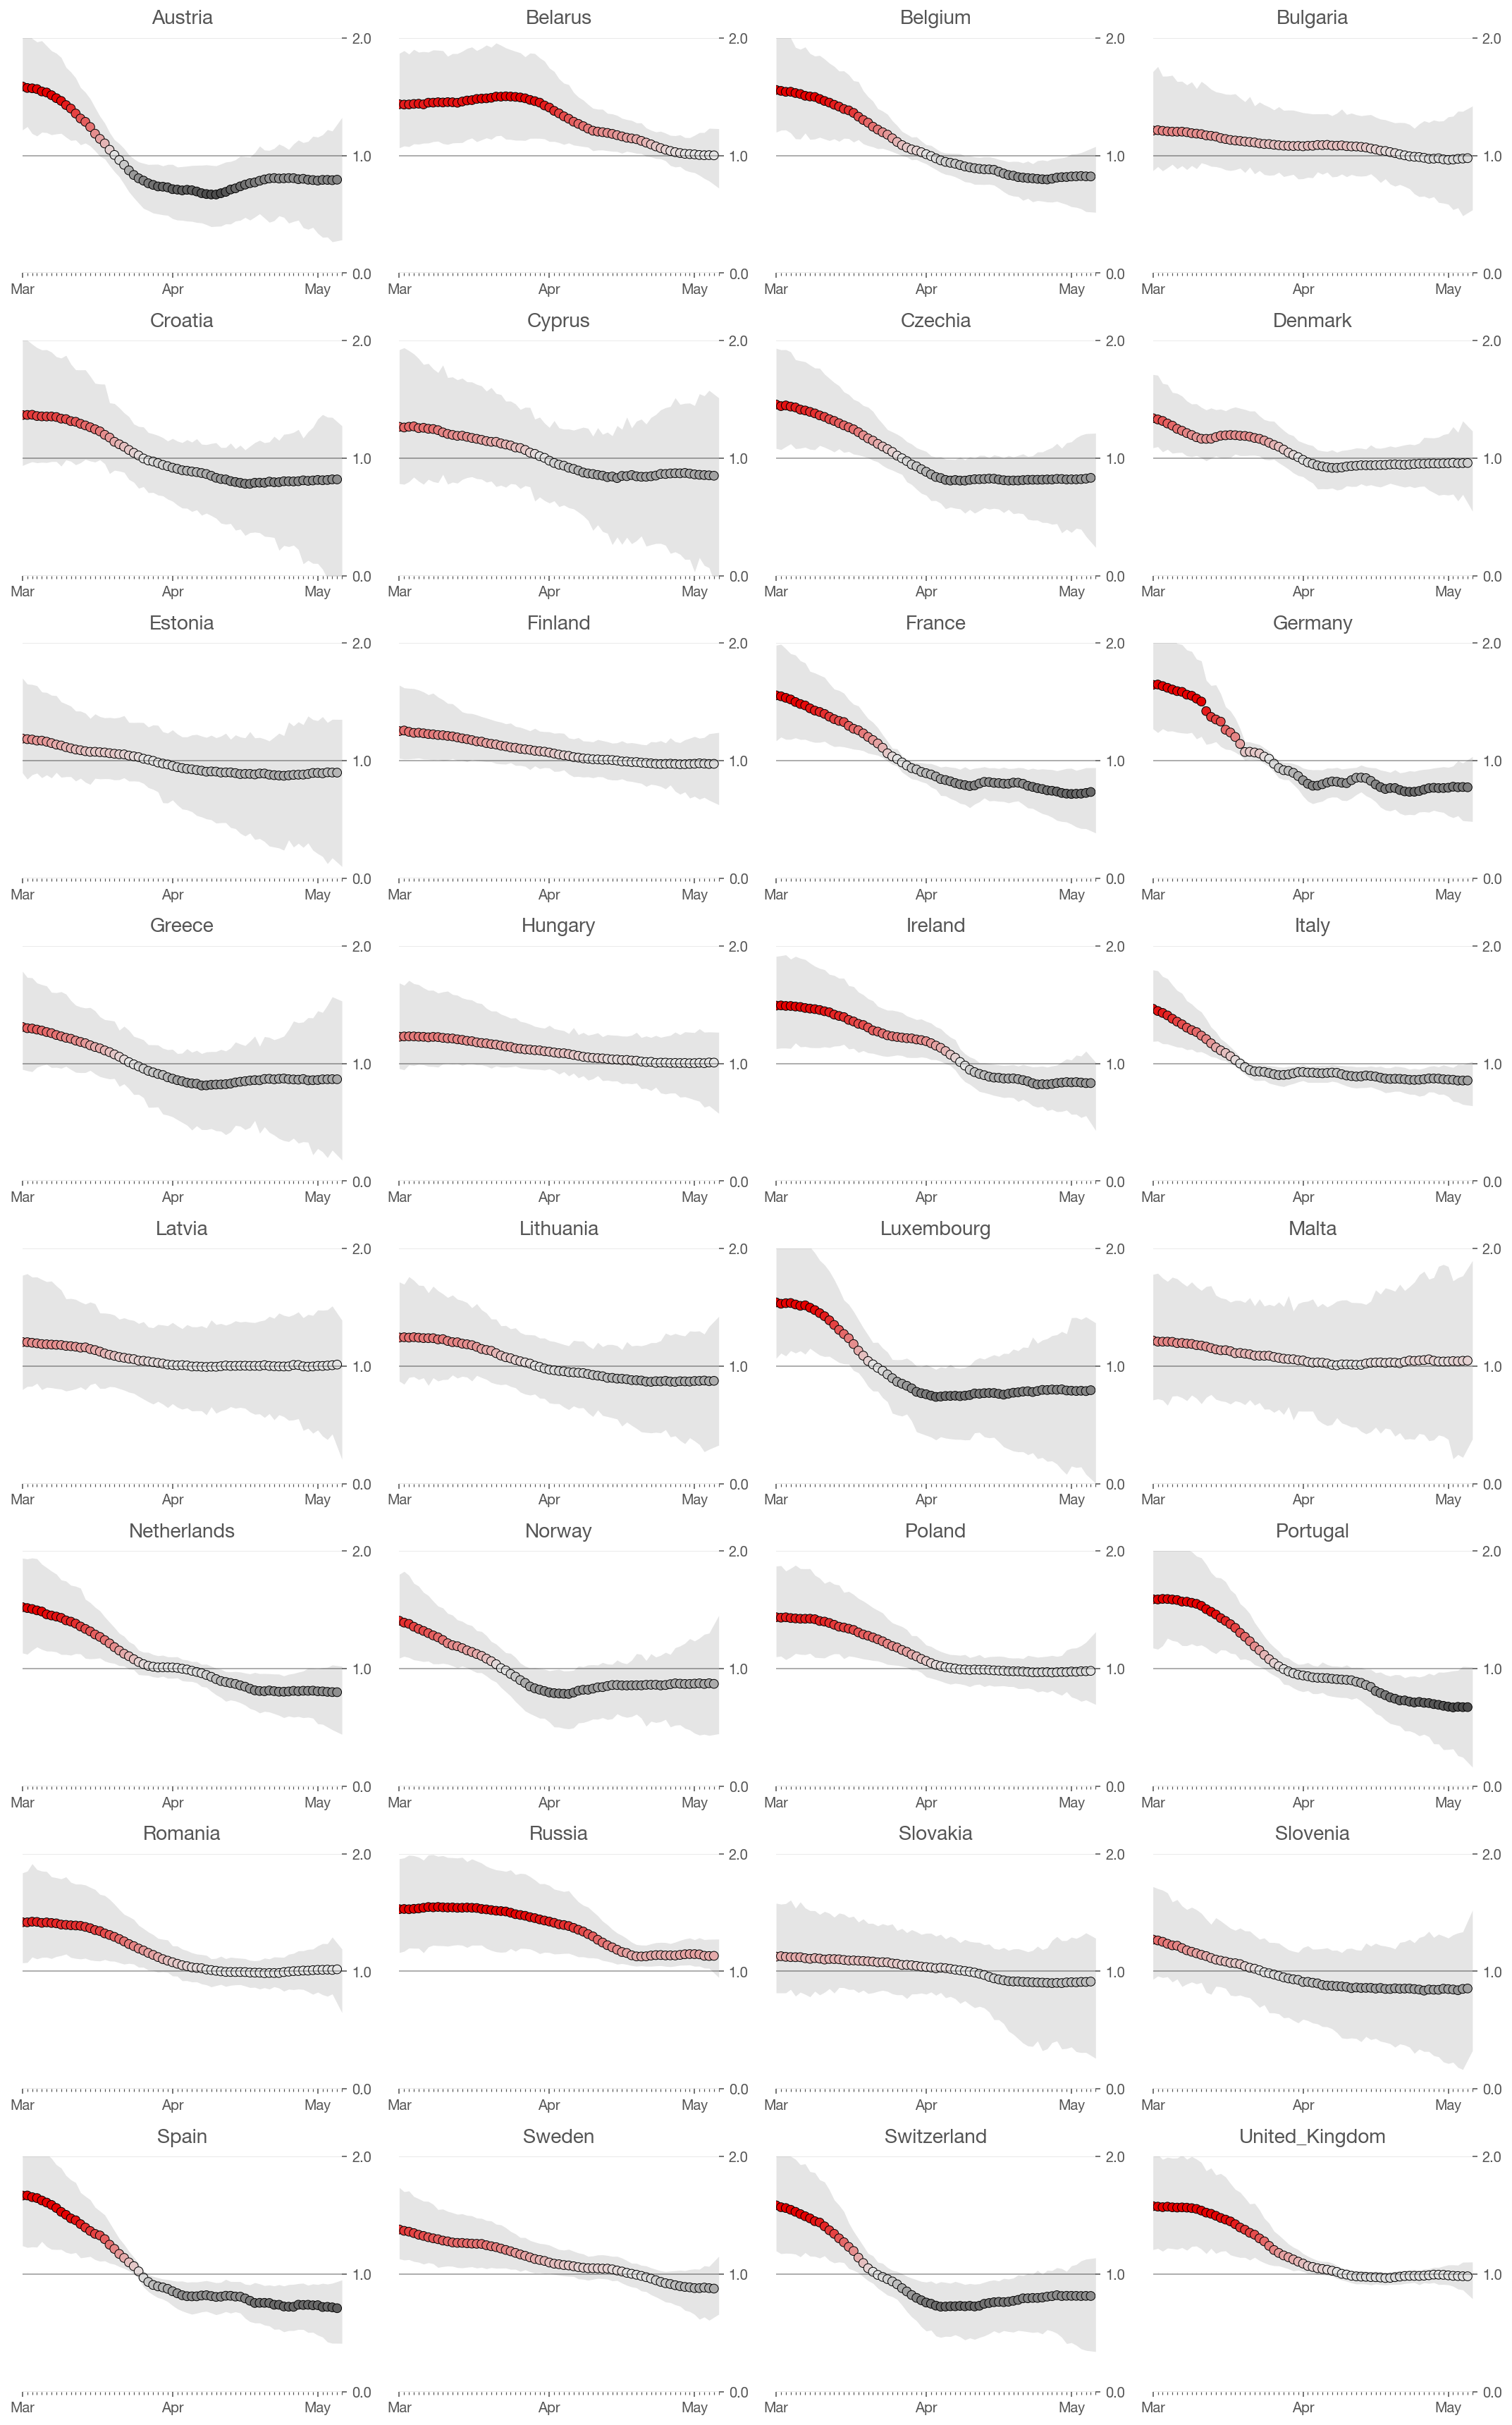

In [6]:
ncountries = len(final_results.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

## Standings

In [7]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [8]:
no_lockdown = []
partial_lockdown = []

In [9]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
    
    too_uncertain = mr.index[(mr['High_90'] - mr['Low_90']) > 1.2]

    for bar, country_name in zip(bars, mr.index):
        if country_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if country_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)
        if country_name in too_uncertain:
            bar.set_alpha(0.3)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    
    if not too_uncertain.empty:
        leg = ax.legend(handles=[
                    Patch(label='Insufficient data or an end of epidemy', color=FULL_COLOR, alpha=0.3),
                ],
#                 title='Lockdown',
#                 ncol=3,
                loc='upper left',
                columnspacing=.75,
                handletextpad=.5,
                handlelength=1)
        leg._legend_box.align = "left"

        
    fig.set_facecolor('w')
    return fig, ax

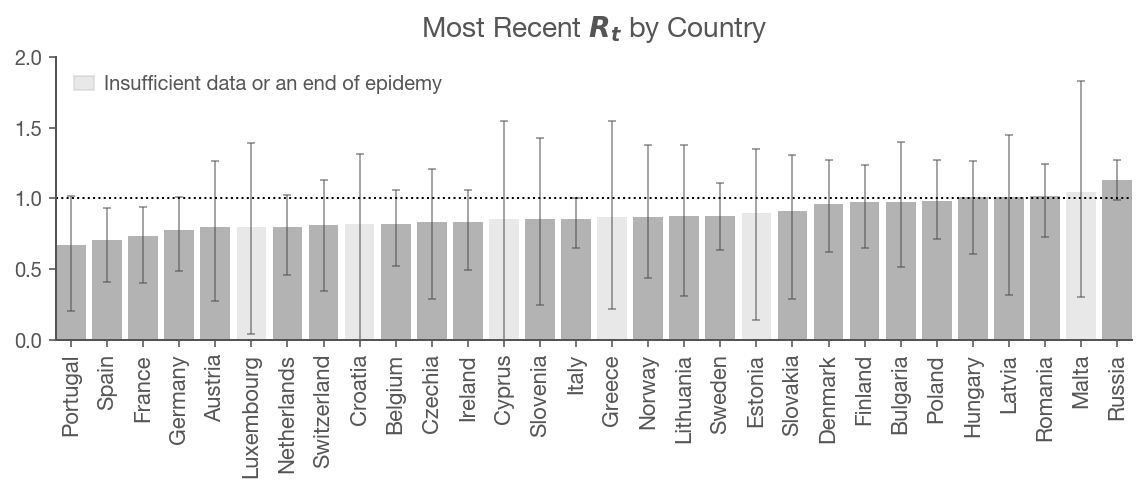

In [10]:
targets = final_results.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr = final_results.loc[targets].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()


mr.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr)

# Rainier

In [11]:
final_results_rainier = pd.read_csv('data/rt-rainier.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['country', 'date'],
                            squeeze=True)

In [12]:
final_results_rainier

ML    Low_90   High_90
country        date                                    
Austria        2020-02-15  1.532932  1.072205  2.021299
               2020-02-16  1.539573  1.066311  1.989567
               2020-02-17  1.549541  1.089278  1.981357
               2020-02-18  1.555873  1.129708  2.018237
               2020-02-19  1.565066  1.147813  2.030001
...                             ...       ...       ...
United_Kingdom 2020-05-01  0.984910  0.887208  1.081589
               2020-05-02  0.979744  0.861498  1.075654
               2020-05-03  0.979516  0.847302  1.069502
               2020-05-04  0.985853  0.863909  1.109759
               2020-05-05  0.985692  0.849971  1.118401

[2592 rows x 3 columns]

In [13]:
final_results_rainier.columns = ['ML', 'Low_90', 'High_90']

In [14]:
final_results_rainier

ML    Low_90   High_90
country        date                                    
Austria        2020-02-15  1.532932  1.072205  2.021299
               2020-02-16  1.539573  1.066311  1.989567
               2020-02-17  1.549541  1.089278  1.981357
               2020-02-18  1.555873  1.129708  2.018237
               2020-02-19  1.565066  1.147813  2.030001
...                             ...       ...       ...
United_Kingdom 2020-05-01  0.984910  0.887208  1.081589
               2020-05-02  0.979744  0.861498  1.075654
               2020-05-03  0.979516  0.847302  1.069502
               2020-05-04  0.985853  0.863909  1.109759
               2020-05-05  0.985692  0.849971  1.118401

[2592 rows x 3 columns]

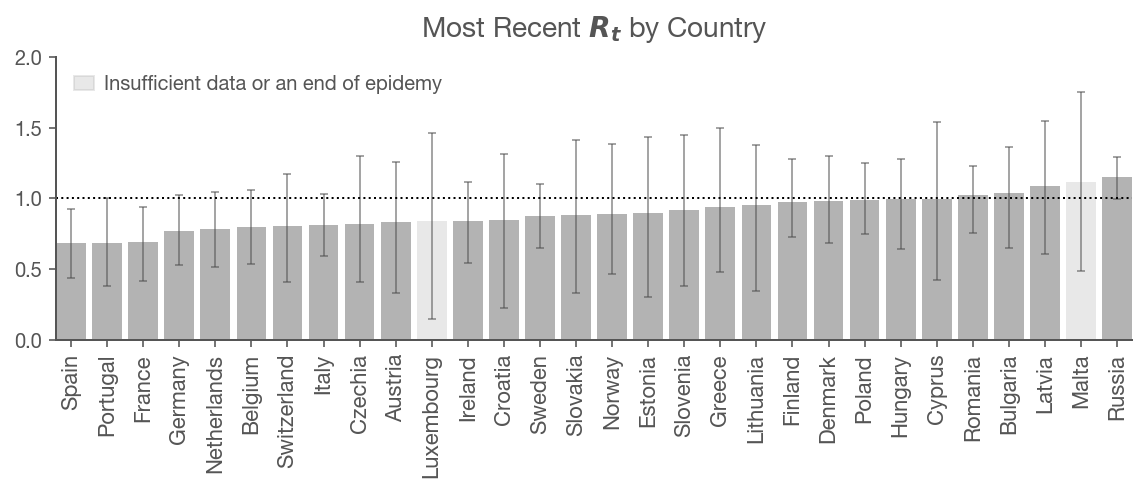

In [15]:
targets_rainier = final_results_rainier.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr_rainier = final_results_rainier.loc[targets_rainier].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_rainier.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr_rainier)

## Compare PYMC3's and Rainier's estimates for European countries

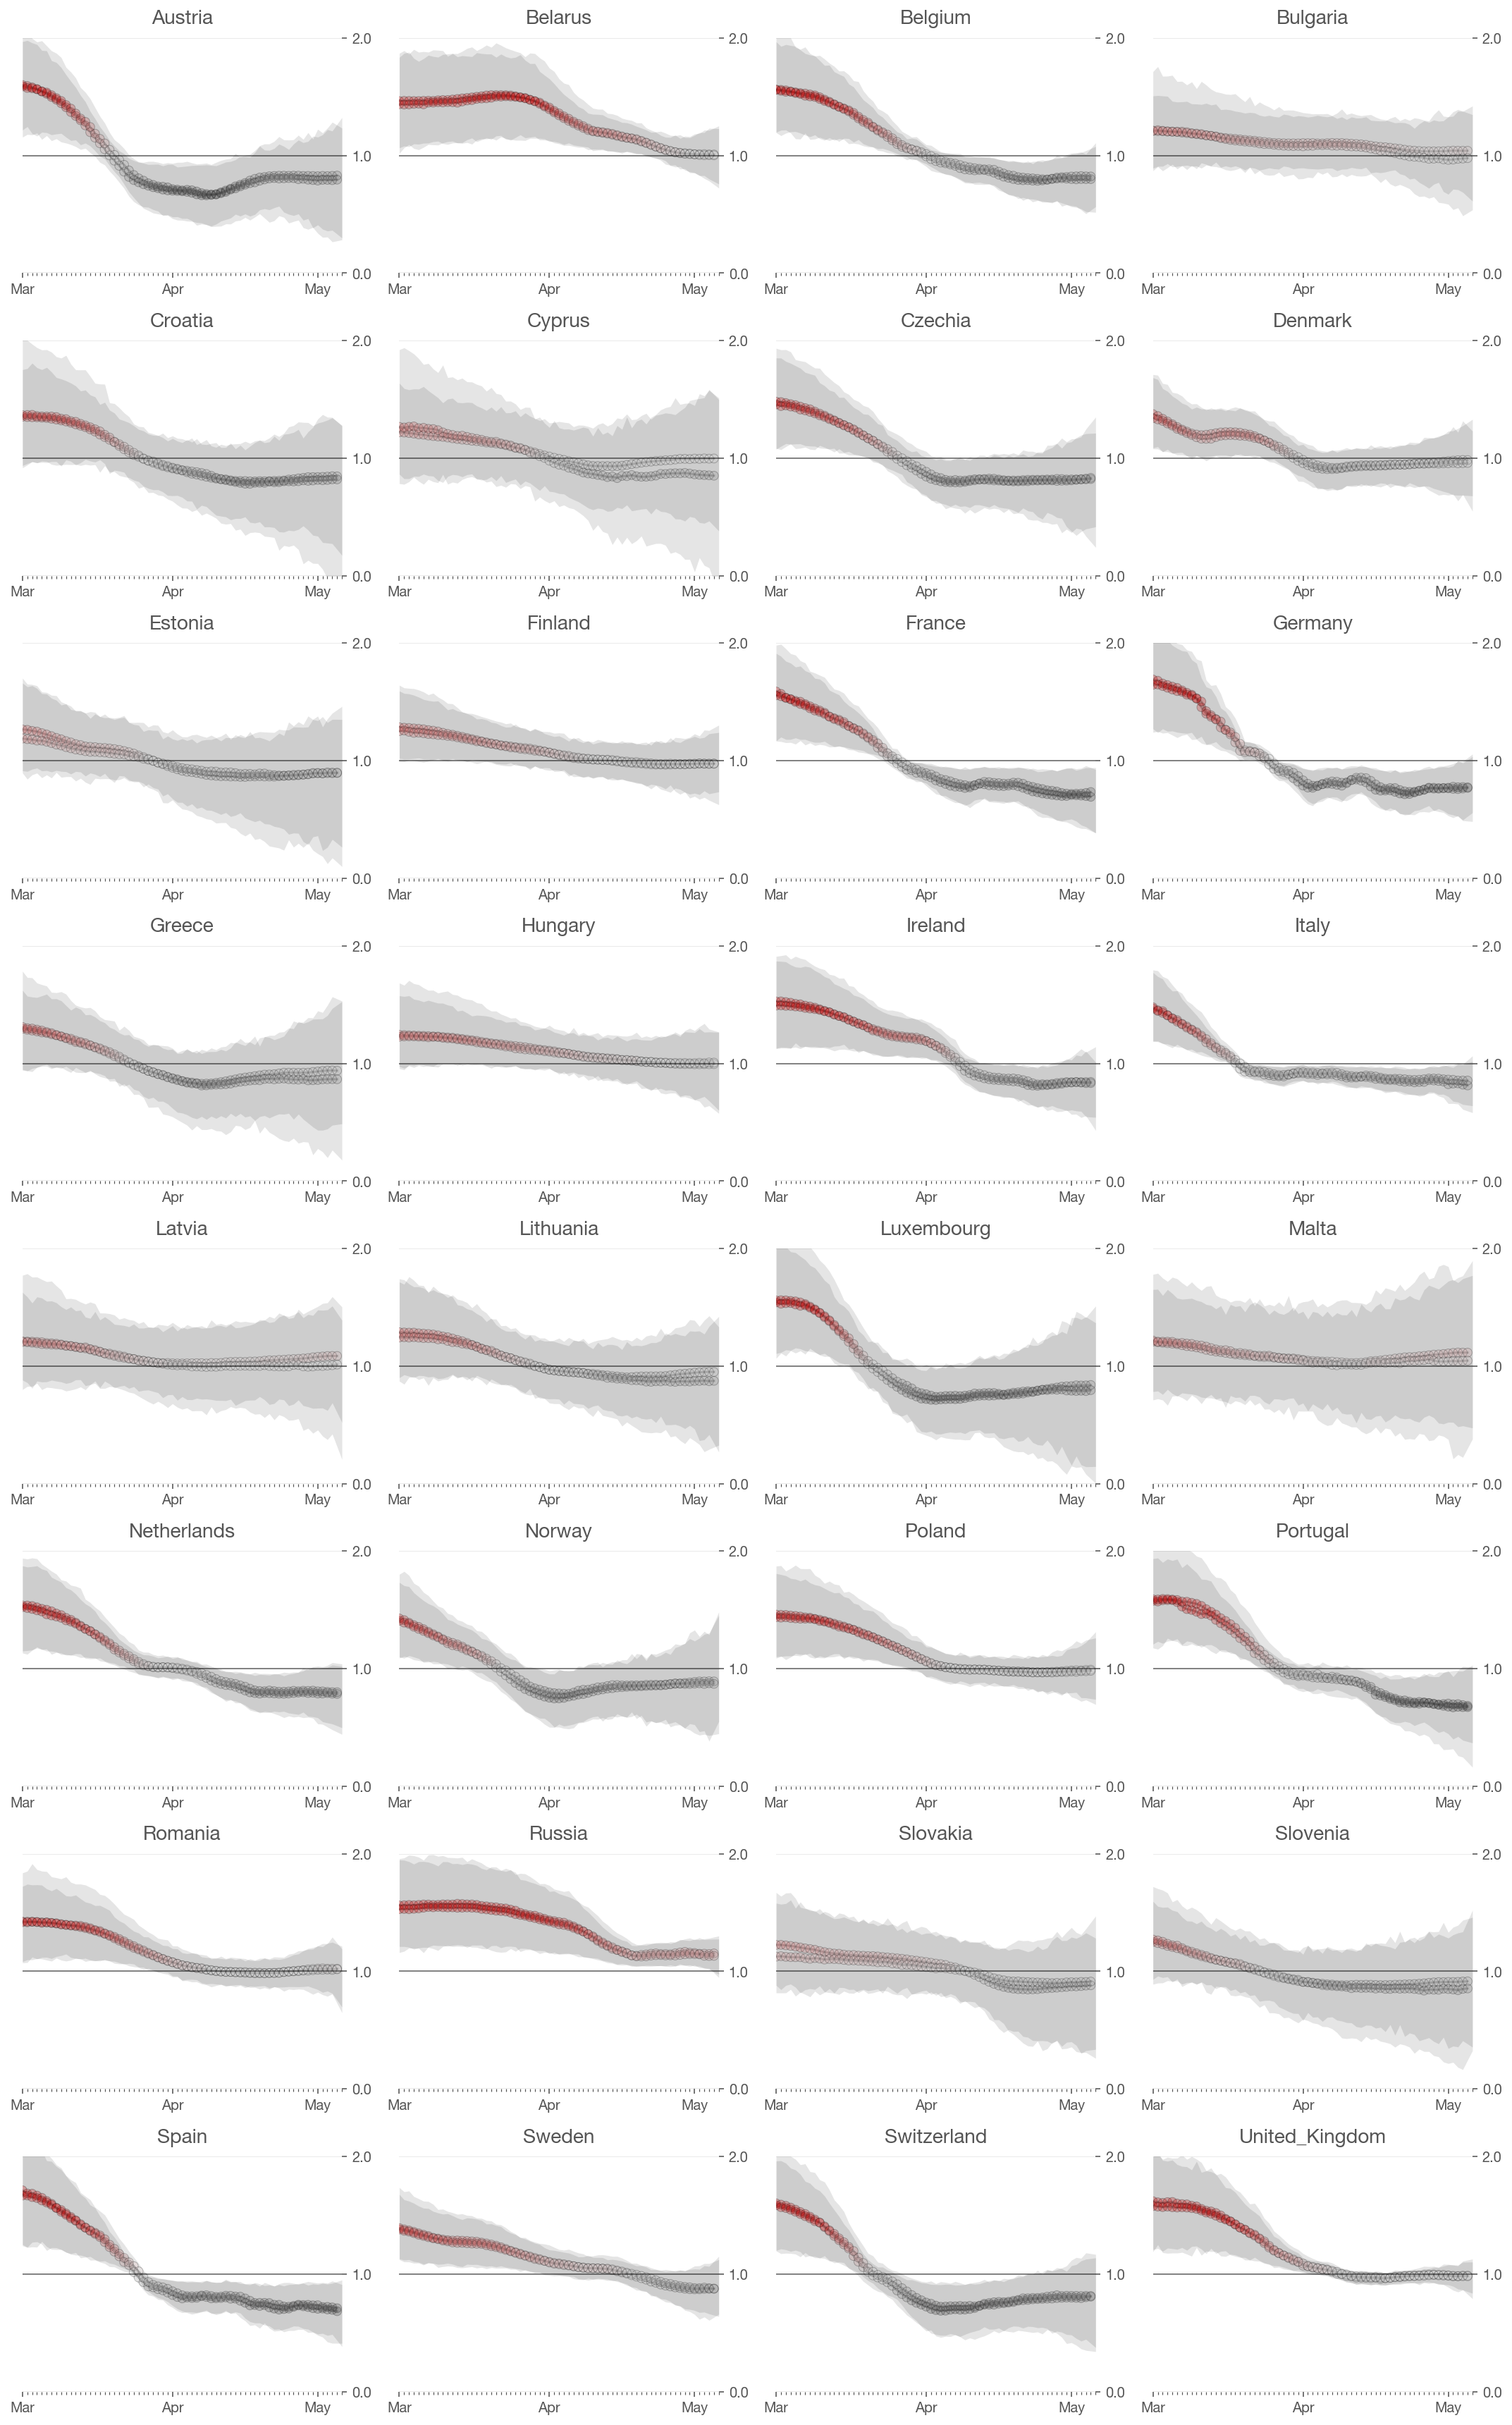

In [18]:
ncountries = len(final_results_rainier.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results_rainier.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name, scatter_alpha=0.25)
    
for i, (country_name, result) in enumerate(final_results.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name, scatter_alpha=0.25)

fig.tight_layout()
fig.set_facecolor('w')